# Scientific Document Classification 

## Import Libraries

In [21]:
# import all required libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.parsing.preprocessing import remove_stopwords
import sklearn
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

## Read Data

In [17]:
# import training data
data = pd.read_csv('./Data/A2_data/train_data_labels.csv')
data

,train_id,abstract,label
0,1,"save for some special cases, current training ...",cs
1,2,we consider a dynamical system with finitely m...,math.DS
2,3,"we consider discrete dynamical systems of ""ant...",cs
3,4,"retrofitting techniques, which inject external...",cs
4,5,approaches to decision-making under uncertaint...,cs
...,...,...,...
29633,29634,"with the powerful deep network architectures, ...",cs
29634,29635,we develop a mixed-characteristic version of t...,math.AG
29635,29636,"in complex analysis, the winding number measur...",cs
29636,29637,we discuss secure computation of modular sum w...,cs


In [9]:
# get unique labels
data.label.unique()    # 100 unique labels

array(['cs', 'math.DS', 'stat.ML', 'q-fin.MF', 'cond-mat.mes-hall',
       'astro-ph.GA', 'cond-mat.soft', 'astro-ph.HE', 'math.LO',
       'math.CO', 'physics.soc-ph', 'physics.optics', 'math.OA',
       'math.AC', 'math.AG', 'math.NT', 'math.AP', 'q-bio.OT', 'math.FA',
       'q-bio.TO', 'math.DG', 'math.RT', 'math.GR', 'cond-mat.str-el',
       'stat.ME', 'cond-mat.stat-mech', 'q-bio.NC', 'physics.bio-ph',
       'q-fin.EC', 'physics.atom-ph', 'astro-ph.CO', 'q-fin.RM',
       'physics.plasm-ph', 'astro-ph.SR', 'math.PR', 'math.KT',
       'cond-mat.supr-con', 'math.IT', 'astro-ph.IM', 'math.GT',
       'q-bio.PE', 'q-bio.QM', 'q-fin.CP', 'math.CA', 'math.MG',
       'q-bio.CB', 'math.CV', 'math.SG', 'math.CT', 'q-bio.GN',
       'q-fin.ST', 'nlin.CD', 'physics.geo-ph', 'physics.chem-ph',
       'nlin.PS', 'physics.flu-dyn', 'physics.atm-clus', 'math.MP',
       'cond-mat.dis-nn', 'q-fin.GN', 'physics.hist-ph',
       'physics.class-ph', 'stat.CO', 'cond-mat.mtrl-sci', 'math.AT',
  

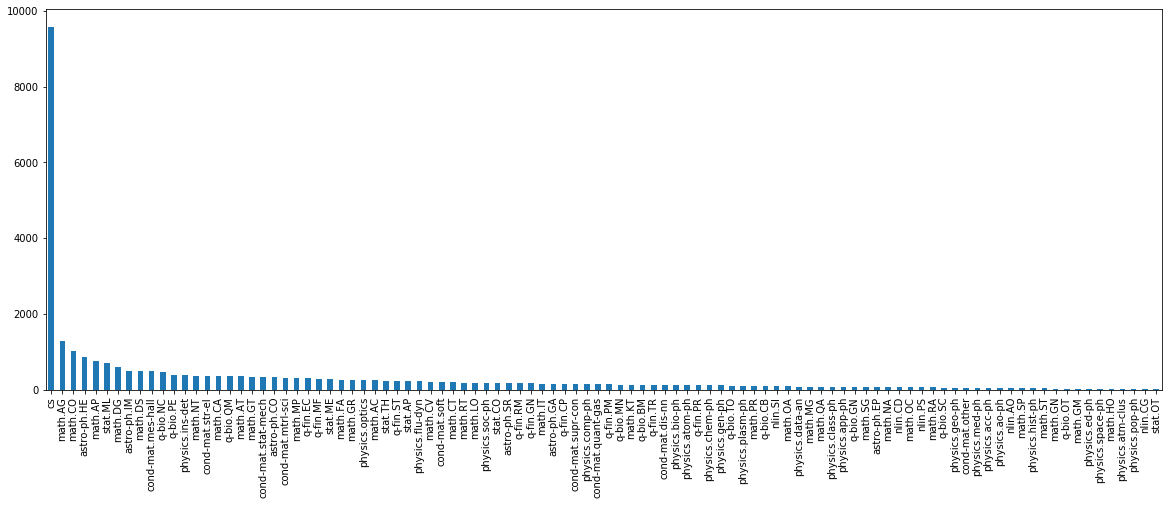

In [10]:
# plot the occurence of labels
plt.figure(figsize=(20,7))
data.label.value_counts().plot(kind='bar')

**Majority labels are 'cs' which is more that 5 times the highest minority label 'math.AG'. Also a lot of document labels belong to different fields of mathematics, example, math.AG, math.CV etc.**

In [16]:
#import test data
data_test = pd.read_csv('./Data/A2_data/test_data.csv')
data_test

,test_id,abstract
0,1,the method of model averaging has become an im...
1,2,unmanned aerial vehicle (uav) systems are bein...
2,3,"in this paper, we propose a new loss function ..."
3,4,we show how to integrate a weak morphism of li...
4,5,caustics occur widely in dynamics and take on ...
...,...,...
7405,7406,statistical inference of evolutionary paramete...
7406,7407,we present a deep learning framework based on ...
7407,7408,t-cell receptor (tcr) repertoire data contain ...
7408,7409,"in this paper, we provide a modern synthesis o..."


## Pre-process the data

In [13]:
# function to remove punctuations from the abstract of the data
def pre_proc(df):
    
    punctuation_signs = list("?:!`.,;:)($/\\><}{='*_+-")
    
    for punct_sign in punctuation_signs:
        df['abstract'] = df['abstract'].str.replace(punct_sign, '')
    
    df['abstract'] = df['abstract'].str.replace('"', "")
    
    return df

In [14]:
# function to lemmatize abstract from the data

def lemmatiz(df):
    
    wordnet_lemmatizer = WordNetLemmatizer()

    nrows = len(df)
    lemmatized_text_list = []

    for row in range(0, nrows):

        # Create an empty list containing lemmatized words
        lemmatized_list = []

        # Save the text and its words into an object
        text = df.loc[row]['abstract']
        text_words = text.split(" ")

        # Iterate through every word to lemmatize
        for word in text_words:
            lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))

        # Join the list
        lemmatized_text = " ".join(lemmatized_list)

        # Append to the list containing the texts
        lemmatized_text_list.append(lemmatized_text)


    df['abstract'] = lemmatized_text_list
    
    return df

In [18]:
# remove punctuations and lemmatize train data
data  = pre_proc(data)
data  = lemmatiz(data)

# remove punctuations and lemmatize test data
data_test  = pre_proc(data_test)
data_test  = lemmatiz(data_test)

## Feature Engineering and Model Development

In [22]:
# split the training data 80/20 ratio
X_train, X_test, y_train, y_test = train_test_split(data['abstract'],data['label'],test_size=0.20,random_state=8)

In [23]:
# import the stopwords list from 'gensim' library
# https://pypi.org/project/gensim/

gensim_stopwords = gensim.parsing.preprocessing.STOPWORDS

# store it in list format
gen_list = list(gensim_stopwords) 

**Now we create a Pipeline in which we extract the features and input the data to estimator.**

In [27]:
# create pipeline

# use gensim stopwords list to remove stopwords

pipe_knn = Pipeline([('vect', CountVectorizer(analyzer='word',stop_words=gen_list, max_df=0.90)),
                     ('tfidf', TfidfTransformer(sublinear_tf=True)),
                     ('knn', KNeighborsClassifier())])

In [28]:
# get the pipeline parameter keys
pipe_knn.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'knn', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'knn__algorithm', 'knn__leaf_size', 'knn__metric', 'knn__metric_params', 'knn__n_jobs', 'knn__n_neighbors', 'knn__p', 'knn__weights'])

**Hyperparameter Tuning using GridSearchCV**

In [34]:
# specify the paramete list for tuning
# due to computational limitations using less parameters

parameters = {'vect__strip_accents':['ascii','unicode'],'vect__ngram_range':[(1,3),(1,2)],'knn__n_neighbors': [23,24,25]}

# initialize the grid
grid_knn = GridSearchCV(pipe_knn, parameters, n_jobs=-1, cv=3)

# input the training data splits
grid_knn_model = grid_knn.fit(X_train, y_train)


print(grid_knn_model.best_score_)
print(grid_knn_model.best_params_)
print(grid_knn_model.best_estimator_)

0.5516239263587872
{'knn__n_neighbors': 24, 'vect__ngram_range': (1, 2), 'vect__strip_accents': 'ascii'}
Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.9, ngram_range=(1, 2),
                                 stop_words=['doesn', 'fifteen', 'own',
                                             'elsewhere', 'there', 'kg',
                                             'seemed', 'side', 'along',
                                             'whatever', 'whereupon', 'up',
                                             'already', 'every', 'amoungst',
                                             'three', 'nothing', 'herein',
                                             'can', 'everyone', 'rather',
                                             'anywhere', 'against', 'go',
                                             'been', 'how', 'though', 'its',
                                             'these', 'alone', ...],
                                 strip_accents='ascii')),
        

In [35]:
# use the best model to make predictions
knn_model = grid_knn_model.best_estimator_

predicted_label = knn_model.predict(X_test)
np.mean(predicted_label == y_test)

0.562246963562753

**Our model gives 56.22% train accuracy. Now we train the model on the whole train dataset and make predictions on the provided test dataset.**

In [38]:
# make final model on whole train data set
final_model = knn_model.fit(data.abstract, data.label)

# make prediction on whole test dataset
predicted_test_labels = final_model.predict(data_test.abstract)

In [39]:
# make new dataframe with predicted labels and export it as .csv file
df = pd.DataFrame(columns=['test_id', 'label'])  
df['label'] = predicted_test_labels
df['test_id'] = np.arange(1, len(df) + 1)
df.to_csv('./pred_labels.csv', index=False)

**Submitting the final prediction file on Kaggle gives 57.04% testing accuracy on 30% test data labels.**